Convolutional Neural Network to Predict Videogame Tags

You're proboably going to need to install some of the packages below to run the program

In [ ]:
#! pip install keras-tuner
#! pip install fast_ml
#! pip install iterative-stratification
#! python --version
#! pip install --upgrade tensorflow
#! pip show tensorflow
#! pip install tensorflow-metal
#! pip install opencv-python

In [1]:
from Library import *
import tensorflow as tf

##Model building
from keras import layers
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, Adagrad
from keras.models import Sequential
from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy, CategoricalCrossentropy
import keras_tuner

##Preprocessing/splitting
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from keras.src.legacy.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from skimage.transform import resize

##Results
from sklearn.metrics import classification_report
from keras.metrics import F1Score, FalseNegatives, FalsePositives, Recall, Precision

##Misc
from tqdm import tqdm ##progress bar for running code
import glob
import matplotlib.pyplot as plt
import random

In [2]:
##LOADING IN THE DATA
Games = pd.read_json('https://seppe.net/aa/assignment2/dataset.json')
print(len(Games)) ##14,687 games


##Creating separate binary columns for all tags
mlb = MultiLabelBinarizer()
Games_tags_df = mlb.fit_transform(Games['tags'])
tags_df = pd.DataFrame(Games_tags_df, columns=mlb.classes_)





14687


In [122]:
##FILTERING OUT TAGS/REMOVING DUPLICATE SCREENSHOTS
List_of_all_tags = mlb.classes_
# print(List_of_all_tags)

#Sum up occurrences of each tag
tag_counts = tags_df.sum()
print(tag_counts)
pd.options.display.max_rows = 445 ##to see all rows in the output
# print(tag_counts)
# print(len(tag_counts))

# Split tags into lists of common and rare
rare_tags = tag_counts[tag_counts < 100].index.tolist()
common_tags = tag_counts[tag_counts > 100].index.tolist()

##Common tags
#print("Tags that appear more than 100 times:")
# print(common_tags)
#print(len(common_tags))

##Rare tags
print("Tags that appear less than 100 times:")
# print(rare_tags)
print(len(rare_tags))


###53 tags manually selected based on a number of criteria
##These were filtered down to 28 tags to try and improve performance
##It is just the second list here we are using
# tags_to_use = ['2D', '3D', 'Action', 'Adventure', 'Anime', 'Arcade', 
#                'Board Game', 'Card Game', 'Cartoony', 'Colorful', 'Combat', 'Cute', 'Dark', 'Driving',
#                'FPS', 'Family Friendly', 'Fantasy', 'First-Person', 'Horror', 'Mystery', 'Old School', 
#                'Pixel Graphics', 'Platformer', 'Puzzle', 'RPG', 'Racing', 'Retro', 'Sci-fi', 'Sexual Content', 'Shooter', 'Side Scroller', 'Simulation', 
#                'Sports', 'Strategy', 'Third Person', 'Top-Down', 'Violent']
tags_to_use = ['2D', '3D', 'Action', 'Adventure', 'Anime', 'Arcade', 
               'Cartoony', 'Colorful', 'Combat', 'Cute', 'Dark',
               'FPS', 'Family Friendly', 'Fantasy', 'First-Person', 'Horror', 'Mystery', 
               'Pixel Graphics', 'Puzzle', 'RPG', 'Retro', 'Sci-fi', 'Shooter', 'Simulation', 
               'Sports', 'Strategy', 'Third Person', 'Top-Down']
print(len(tags_to_use))
final_tags = tags_df[tags_to_use]



##Need to check if any games are without tags after filtering tags
no_final_tags = final_tags.loc[(final_tags==0).all(axis=1)]
print(len(no_final_tags))
###39 instances with no tagging of any of the final 28 tags
##these instances can be removed (or maybe should be left in?)


##Concatenating original videogame columns with binary columns of final tags
Games_binary_tags = pd.concat([Games, final_tags], axis=1)
##Filtering out games with no tags
Games_binary_tags = Games_binary_tags[Games_binary_tags.iloc[:, 9:].sum(axis=1)!=0]

print(len(Games_binary_tags))
#print(Games_binary_tags.columns[9:])


###Removing two instances that use duplicate screenshots of another instance (Collector's editions of the same game)
Games_binary_tags = Games_binary_tags.drop(Games_binary_tags[Games_binary_tags['appid'] == '2131630,2131640,2131650,2131680,2306740'].index)
Games_binary_tags = Games_binary_tags.drop(Games_binary_tags[Games_binary_tags['appid'] == '2131630,2131680'].index)


Games = pd.DataFrame(Games_binary_tags, columns=['appid', 'screenshots', 'title', 'tags'])
Tags = pd.DataFrame(Games_binary_tags, columns=tags_to_use)

print(len(Games))
print(len(Tags))


###Dropped zombies, solitaire, logic, magic, hand-drawn, futuristic, cyberpunk, war, building, third person shooter, 
# top down shooter, exploration, 2d fighter, 2d platformer, 3d fighter, 3d platformer

##Furtherly dropping any tags not in the second list above


1980s                                  591
1990's                                 760
2.5D                                   491
2D                                    5927
2D Fighter                             287
2D Platformer                         1598
360 Video                               25
3D                                    5297
3D Fighter                             281
3D Platformer                         1139
3D Vision                              178
4 Player Local                         263
4X                                     100
6DOF                                   178
8-bit Music                             20
ATV                                      6
Abstract                               535
Action                                6713
Action RPG                            1023
Action RTS                             154
Action Roguelike                      1163
Action-Adventure                      2666
Addictive                                9
Adventure  

In [4]:
##TRAIN-TEST-VALIDATION SPLIT
## Splitting while trying to keep proprtion of positive to negative values equal 
## for each tag across the three datasets

##This function is based on algorithm proposed in:
# Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of
# Multi-Label Data. In: Gunopulos D., Hofmann T., Malerba D., Vazirgiannis M.
# (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD
# 2011. Lecture Notes in Computer Science, vol 6913. Springer, Berlin, Heidelberg.

###Need to be np arrays
Games_array = Games.to_numpy()
Tags_array = Tags.to_numpy()

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0)

##train and test split based off of tags dataframe
for train_index, test_index in msss.split(Games_array, Tags_array):
    X_train, X_test = Games_array[train_index], Games_array[test_index]
    y_train, y_test = Tags_array[train_index], Tags_array[test_index]
    
##now splitting test set into test and validation
mssstv = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=.5, random_state=0)

##train and test split based off of tags dataframe
for test_index, valid_index in mssstv.split(X_test, y_test):
    X_valid, X_test = X_test[valid_index], X_test[test_index]
    y_valid, y_test = y_test[valid_index], y_test[test_index]


X_train = pd.DataFrame(X_train, columns=Games.columns)
y_train = pd.DataFrame(y_train, columns =Tags.columns)

X_valid = pd.DataFrame(X_valid, columns=Games.columns)
y_valid = pd.DataFrame(y_valid, columns = Tags.columns)

X_test = pd.DataFrame(X_test, columns=Games.columns)
y_test = pd.DataFrame(y_test, columns =Tags.columns)

Train_DF = pd.concat([X_train, y_train], axis=1)   
Valid_DF = pd.concat([X_valid, y_valid], axis=1) 
Test_DF = pd.concat([X_test, y_test], axis=1) 


print(len(Train_DF))
print(len(Valid_DF))
print(len(Test_DF))

##separate column for every screeshot
Train_DF = Train_DF.explode('screenshots')
Valid_DF = Valid_DF.explode('screenshots')
Test_DF = Test_DF.explode('screenshots')


print(len(Train_DF))
print(len(Valid_DF))
print(len(Test_DF))

###To calculate number of steps per epoch later on
N_train_instances = len(Train_DF)
N_valid_instances = len(Valid_DF)
N_test_instances = len(Test_DF)

##Randomly shuffle Train_DF so screenshots aren't ordered by games (this will affect training outcomes)
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
#print(len(Train_DF))
#print(Train_DF.head(5))




###IGNORE FOR NOW
# ###Making dataframes where the true labels for each instance sum up to 1 (for a different loss function)
# N_1_Train = Train_DF.iloc[:, 4:].sum(axis=1) ##n of true labels for each instance
# CCE_Labels1 = Train_DF.iloc[:, 4:].astype(float).div(N_1_Train, axis=0)
# Train_DF_CCE = pd.concat([Train_DF.iloc[:, :4], CCE_Labels1], axis=1)


# N_1_Valid = Valid_DF.iloc[:, 4:].sum(axis=1) ##n of true labels for each instance
# CCE_Labels2 = Valid_DF.iloc[:, 4:].astype(float).div(N_1_Valid, axis=0)
# Valid_DF_CCE = pd.concat([Valid_DF.iloc[:, :4], CCE_Labels2], axis=1)

# N_1_Test = Test_DF.iloc[:, 4:].sum(axis=1) ##n of true labels for each instance
# CCE_Labels3 = Test_DF.iloc[:, 4:].astype(float).div(N_1_Test, axis=0)
# Test_DF_CCE = pd.concat([Test_DF.iloc[:, :4], CCE_Labels3], axis=1)

# print(Train_DF_CCE.head(5))


11672
1495
1479
102069
13336
12846


In [6]:
###CREATING AND SAVING 299X299 IMAGES FROM ORIGINAL IMAGES
##Doing this every time we train a model/for every epoch is very computationally intense

# def preprocess_and_save_images(DF, source_dir, save_dir, target_size=(299, 299), crop_size=897):
#     os.makedirs(save_dir, exist_ok=True)
#     for row in tqdm(DF.iterrows()):
#         # Read image
#         img_path = os.path.join(source_dir, row[1]['screenshots'])  # Access row data using row[1]
#         try:
#             img = cv2.imread(img_path)
#             # Resize
#             img = resize(img, target_size, anti_aliasing=True, preserve_range=True)

#             # Save preprocessed image with original filename
#             filename = os.path.basename(img_path)
#             save_path = os.path.join(save_dir, filename)
#             cv2.imwrite(save_path, img)
#         except Exception as e:
#             print(f"Error processing image {img_path}: {e}")

# source_directory = '/Users/sammcmanagan/AA Assignment 2/images'
# save_directory = '/Users/sammcmanagan/AA Assignment 2/resized_images'


In [14]:
#preprocess_and_save_images(Train_DF, source_directory, save_directory)
#preprocess_and_save_images(Valid_DF, source_directory, save_directory)
#preprocess_and_save_images(Test_DF, source_directory, save_directory)

7537it [11:37, 12.34it/s][ WARN:0@11849.580] global loadsave.cpp:248 findDecoder imread_('/Users/sammcmanagan/AA Assignment 2/images/1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg'): can't open/read file: check file path/integrity


Error processing image /Users/sammcmanagan/AA Assignment 2/images/1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg: 'NoneType' object has no attribute 'shape'


7543it [11:38, 10.31it/s][ WARN:0@11850.301] global loadsave.cpp:248 findDecoder imread_('/Users/sammcmanagan/AA Assignment 2/images/1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg'): can't open/read file: check file path/integrity
7545it [11:38, 12.13it/s]

Error processing image /Users/sammcmanagan/AA Assignment 2/images/1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg: 'NoneType' object has no attribute 'shape'


13336it [20:47, 10.69it/s]
12846it [20:07, 10.64it/s]


In [5]:
###LOADING IMAGES IN BATCHES
###This whole step is so that the images are only loaded into memory and used for training in batches

def preprocess_input_img(x):
    x = keras.applications.xception.preprocess_input(x)
    return x

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_img ##This is a preprocessing function required by the Xception model
    ##might be a good idea to add some data augmentation here
)

# Define batch size
batch_size = 32

# Create a generator for each dataset
train_generator = datagen.flow_from_dataframe(
    dataframe=Train_DF,
    directory='/Users/sammcmanagan/AA Assignment 2/resized_images',
    x_col="screenshots",
    y_col=tags_to_use,
    batch_size=batch_size,
    class_mode="raw",
    shuffle=False
    )

valid_generator = datagen.flow_from_dataframe(
    dataframe=Valid_DF,
    directory='/Users/sammcmanagan/AA Assignment 2/resized_images',
    x_col="screenshots",
    y_col=tags_to_use,
    batch_size=batch_size,
    class_mode="raw",
    shuffle=False
    )

test_generator = datagen.flow_from_dataframe(
    dataframe=Test_DF,
    directory='/Users/sammcmanagan/AA Assignment 2/resized_images',
    x_col="screenshots",
    y_col=tags_to_use,
    batch_size=batch_size,
    class_mode="raw",
    shuffle=False
    )




Found 102068 validated image filenames.


/Users/sammcmanagan/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="screenshots". These filename(s) will be ignored.
  warnings.warn(


Found 13334 validated image filenames.
Found 12846 validated image filenames.


/Users/sammcmanagan/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="screenshots". These filename(s) will be ignored.
  warnings.warn(


In [6]:
###CALCULATING CLASS WEIGHTS FOR TAGS
## This is to add more weight to tags that are poorly represented in the dataset
class_freqs = Train_DF.iloc[:, 4:].sum()

total_samples = len(Train_DF)
inverse_frequencies = total_samples / class_freqs

# Normalize weights
class_weights = {class_label: weight / sum(inverse_frequencies) for class_label, weight in inverse_frequencies.items()}

print(class_weights)

{'2D': 0.01450832640945486, '3D': 0.01395355677946979, 'Action': 0.011029206204191573, 'Adventure': 0.012431862079362655, 'Anime': 0.06276034189683335, 'Arcade': 0.03226075600713563, 'Cartoony': 0.05034102570182959, 'Colorful': 0.02091285759586932, 'Combat': 0.030214706611727895, 'Cute': 0.02820154441245368, 'Dark': 0.05146300417678502, 'FPS': 0.05852307118636985, 'Family Friendly': 0.040986926205908394, 'Fantasy': 0.027815558542137648, 'First-Person': 0.024078182287895867, 'Horror': 0.039429291966285515, 'Mystery': 0.05619572452775696, 'Pixel Graphics': 0.02767934687002761, 'Puzzle': 0.02667383945534195, 'RPG': 0.02658367215559579, 'Retro': 0.04448847389030263, 'Sci-fi': 0.04058836981374981, 'Shooter': 0.03472139211927446, 'Simulation': 0.022515598175934494, 'Sports': 0.0994184529204876, 'Strategy': 0.023980286195864474, 'Third Person': 0.038456833170802354, 'Top-Down': 0.03978779264115129}


In [ ]:
###MODEL BUILDING
##Using keras tuner for choosing hyperparameters
def build_model(hp):
    ###all the hyperparameters tuned by keras tuner
    learn_rate = hp.Float("Learning Rate", min_value=1e-5, max_value=1e-2, sampling="log")
    dropout_rate = hp.Float("Dropout", min_value=.2, max_value=.5, sampling="log")
    N_neurons1 = hp.Int("N_neurons_layer1", min_value=384, max_value=512, step=128)
    N_neurons2 = hp.Int("N_neurons_layer2", min_value=256, max_value=512, step=128)
    N_neurons3 = hp.Int("N_neurons_layer3", min_value=256, max_value=512, step=128)
    N_neurons4 = hp.Int("N_neurons_layer4", min_value=128, max_value=512, step=128)
    activation_fun = hp.Choice("Activation function", ["relu", "lrelu"])
    loss_fun = hp.Choice("Loss function", [BinaryCrossentropy(), BinaryFocalCrossentropy()])
    optimizer = hp.Choice("Optimizer", [Adam, Adagrad])
    
    
    cnn = Sequential()

    Xception = keras.applications.Xception(include_top=False, weights="imagenet")
    for layer in Xception.layers:
        layer.trainable=False  ##Freeze all Xception layers so they aren't trained
    cnn.add(Xception)
    cnn.add(Flatten())
    
    ##Fully connected layer 1
    cnn.add(Dense(N_neurons1, activation= 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_rate))
    ##Fully connected layer 2
    cnn.add(Dense(N_neurons2, activation= 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_rate))
    ##Fully connected layer 3   
    cnn.add(Dense(N_neurons3, activation= 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_rate))
    ##Fully connected layer 4   
    cnn.add(Dense(N_neurons4, activation= 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_rate))   

    
    ##Output layer (sigmoid instead of softmax, as all outputs should be independent pdfs)
    cnn.add(Dense(28, activation='sigmoid'))
    
    cnn.compile(
        optimizer = Adam(learning_rate=learn_rate),
        loss= "binary_crossentropy",
        metrics = [F1Score(average="weighted", threshold=.25), Precision(thresholds=.25), Recall(thresholds=.25)]
    )
    #print(Xception.summary())
    #print(cnn.summary())    
    return cnn



tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective= keras_tuner.Objective("val_f1_score", direction="max"), ##May be better to use val_loss
    directory='/Users/sammcmanagan/Library/Mobile Documents/com~apple~CloudDocs/Documents/M.Sc Statistics & Data Science/Advanced Analytics/Assignment 2/Tuner Results',
    executions_per_trial=2, ##Each combination of parameters tested twice
    max_trials=15, ##Test 15 different combinations of hyperparameters
    project_name="CNN Hyperparameters",
    #overwrite=True ##This deletes results from previous tuner searches
)




tuner.search(train_generator, 
             epochs=3, 
             validation_data=valid_generator,
             #best_model = tuner.get_best_models()[0]
             )



In [7]:
###RETRAINING CHOSEN MODEL
cnn = Sequential()

Xception = keras.applications.Xception(include_top=False, weights="imagenet")
for layer in Xception.layers:
    layer.trainable=False  ##Freeze all Xception layers so they aren't trained
cnn.add(Xception)
cnn.add(Flatten())

##Fully connected layer 1
cnn.add(Dense(512, activation= 'relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(.35))
##Fully connected layer 2
cnn.add(Dense(384, activation= 'relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(.25))
##Fully connected layer 3   
cnn.add(Dense(256, activation= 'relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(.25))
##Fully connected layer 4   
cnn.add(Dense(128, activation= 'relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(.25))   


##Output layer (sigmoid instead of softmax, as all outputs should be independent pdfs)
cnn.add(Dense(28, activation='sigmoid'))

cnn.compile(
    optimizer = Adam(learning_rate=.0001),
    loss= "binary_crossentropy",
    metrics = [F1Score(average="weighted", threshold=.25), Precision(thresholds=.25), Recall(thresholds=.25)]
)



2024-05-24 20:20:41.071620: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-24 20:20:41.071646: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-24 20:20:41.071649: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-24 20:20:41.071672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-24 20:20:41.071685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=3)

history = cnn.fit(train_generator, 
                    validation_data = valid_generator,
                    epochs=15, batch_size=1, callbacks=[callback],
                    verbose=1)

len(history.history['val_loss'])

Epoch 1/15


2024-05-24 20:20:48.544277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/sammcmanagan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3190/3190 ━━━━━━━━━━━━━━━━━━━━ 1355s 423ms/step - f1_score: 0.4045 - loss: 0.6802 - precision: 0.2239 - recall: 0.8267 - val_f1_score: 0.4818 - val_loss: 0.3941 - val_precision: 0.4499 - val_recall: 0.5834
Epoch 2/15
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 1338s 419ms/step - f1_score: 0.4679 - loss: 0.4151 - precision: 0.4081 - recall: 0.5884 - val_f1_score: 0.5024 - val_loss: 0.3856 - val_precision: 0.4466 - val_recall: 0.6206
Epoch 3/15
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 1321s 414ms/step - f1_score: 0.4953 - loss: 0.3974 - precision: 0.4326 - recall: 0.6160 - val_f1_score: 0.5067 - val_loss: 0.3836 - val_precision: 0.4510 - val_recall: 0.6176
Epoch 4/15
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 1320s 413ms/step - f1_score: 0.5137 - loss: 0.3853 - precision: 0.4471 - recall: 0.6362 - val_f1_score: 0.5115 - val_loss: 0.3828 - val_precision: 0.4442 - val_recall: 0.6360
Epoch 5/15
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 1321s 414ms/step - f1_score: 0.5263 - loss: 0.3769 - precision: 0.4566 - recall: 0.6502 - val_f1_scor

8

In [10]:
##SAVING THE MODEL
cnn.save("/Users/sammcmanagan/Library/Mobile Documents/com~apple~CloudDocs/Documents/M.Sc Statistics & Data Science/Advanced Analytics/CNN-Videogame-Genres/Assignment 2/FinalModel2.keras")

In [123]:
###REPORT FOR BINARY CROSS ENTROPY (BCE) MODEL

# # Get the predicted probabilities for the validation/test set
# valid_generator.reset()
# y_pred_prob = cnn.predict(valid_generator)

# Get the ground truth labels for the validation/test set
y_true = valid_generator.labels

# Threshold the predicted probabilities to obtain binary predictions
y_pred = (y_pred_prob > 0.25).astype(int) ##Probably optimal around .2 for most tags

# Calculate classification report
report = classification_report(y_true, y_pred, target_names=tags_to_use)

print(report)

ValueError: Found input variables with inconsistent numbers of samples: [13334, 12846]

In [ ]:
##LOADING THE MODEL

# Load the saved model
loaded_model = keras.models.load_model('/Users/sammcmanagan/Library/Mobile Documents/com~apple~CloudDocs/Documents/M.Sc Statistics & Data Science/Advanced Analytics/CNN-Videogame-Genres/Assignment 2/Tuner Results/CNN Hyperparameters/trial_03/checkpoint.weights.h5')

In [22]:
##OPTIMISING F1 SCORE FOR EACH TAG WITH INDIVIDUAL THRESHOLDS
##All of this code (and all of the code from the cells below) is just copied straight from
## https://github.com/vanHavel/games-cnn/tree/master/predict
##It will need to be tailored to our project

##It has been tailored
train_generator.reset()

def get_f1_score_for_label(label_id, y_pred, y_true, cutoff):
    # project to component
    y_pred = y_pred[:,label_id]
    y_true = y_true[:,label_id]
    
    # transform predictions to binary matrix
    fun = lambda x: 1 if x >= cutoff else 0
    vfunc = np.vectorize(fun)
    y_pred = vfunc(y_pred)
    
    # calculate f1 score
    true_and_predicted = np.sum(y_true * y_pred)
    true = np.sum(y_true)
    predicted = np.sum(y_pred)
    if predicted == 0 or true == 0:
        return -1
    recall = true_and_predicted / true
    precision = true_and_predicted / predicted
    f1_score = 2 * (recall * precision) / (recall + precision)
    
    return f1_score
# get optimal thresholds for each label on the training data, maximizing F1 score

model_path = "/Users/sammcmanagan/Library/Mobile Documents/com~apple~CloudDocs/Documents/M.Sc Statistics & Data Science/Advanced Analytics/CNN-Videogame-Genres/Assignment 2/FinalModel.keras"

# model_path: path to keras model
def get_cutoffs():
    
    # load training data
    y_true = train_generator.labels

    # load model
    #model = keras.models.load_model(model_path)
    model = cnn
    
    # get predictions
    y_pred = model.predict(train_generator)
    
    
    # calculate optimal cutoff point for each label separately
    k = np.shape(y_true)[1]
    cutoffs = np.zeros(k)
    for label_id in range(k):
        print("label " + str(label_id))
        # get candidates
        possible_cutoffs = np.arange(0.01, 0.61, 0.01)
        best_cutoff = -1
        best_f1 = -1
        # try each candidate, comparing f1 scores
        possible_cutoffs = np.sort(possible_cutoffs)
        for i in range(0, len(possible_cutoffs)):
            candidate = possible_cutoffs[i]
            f1_score = get_f1_score_for_label(label_id, y_pred, y_true, cutoff=candidate)
            if f1_score > best_f1:
                best_f1 = f1_score
                best_cutoff = candidate
        cutoffs[label_id] = best_cutoff
        print(best_cutoff)
        
    # write cutoffs
    #np.save(os.path.join('cutoffs', 'cutoffs.npy'), cutoffs)
    return cutoffs

cutoffs = get_cutoffs()



3190/3190 ━━━━━━━━━━━━━━━━━━━━ 967s 303ms/step
label 0
0.43
label 1
0.41000000000000003
label 2
0.35000000000000003
label 3
0.31
label 4
0.24000000000000002
label 5
0.24000000000000002
label 6
0.18000000000000002
label 7
0.29000000000000004
label 8
0.22
label 9
0.29000000000000004
label 10
0.19
label 11
0.24000000000000002
label 12
0.23
label 13
0.24000000000000002
label 14
0.34
label 15
0.24000000000000002
label 16
0.18000000000000002
label 17
0.28
label 18
0.25
label 19
0.27
label 20
0.17
label 21
0.22
label 22
0.25
label 23
0.32
label 24
0.19
label 25
0.36000000000000004
label 26
0.27
label 27
0.26


In [124]:
###PREDICT VALUES BASED ON CUSTOM THRESHOLDS

valid_generator.reset()
y_pred_prob = cnn.predict(valid_generator)

# Get the ground truth labels for the validation/test set
y_true = valid_generator.labels

# Ensure the predicted probabilities and thresholds align
assert y_pred_prob.shape[1] == len(cutoffs), "Number of thresholds must match the number of labels"

# Apply thresholds to get binary predictions for each label
y_pred = np.zeros_like(y_pred_prob)
for i, threshold in enumerate(cutoffs):
    y_pred[:, i] = (y_pred_prob[:, i] > threshold).astype(int)
# Calculate classification report
report = classification_report(y_true, y_pred, target_names=tags_to_use)

print(report)

417/417 ━━━━━━━━━━━━━━━━━━━━ 135s 323ms/step
0.43
0.41000000000000003
0.35000000000000003
0.31
0.24000000000000002
0.24000000000000002
0.18000000000000002
0.29000000000000004
0.22
0.29000000000000004
0.19
0.24000000000000002
0.23
0.24000000000000002
0.34
0.24000000000000002
0.18000000000000002
0.28
0.25
0.27
0.17
0.22
0.25
0.32
0.19
0.36000000000000004
0.27
0.26
                 precision    recall  f1-score   support

             2D       0.69      0.81      0.75      4912
             3D       0.61      0.80      0.69      5002
         Action       0.62      0.79      0.69      6431
      Adventure       0.53      0.73      0.62      5715
          Anime       0.40      0.40      0.40      1095
         Arcade       0.32      0.40      0.35      2311
       Cartoony       0.25      0.42      0.32      1392
       Colorful       0.39      0.55      0.46      3362
         Combat       0.29      0.50      0.37      2321
           Cute       0.41      0.54      0.46      2493
       

In [28]:
##FINAL PREDICTION USING HOLDOUT SET
test_generator.reset()
y_pred_prob = cnn.predict(test_generator)

# Get the ground truth labels for the validation/test set
y_true = test_generator.labels

# Ensure the predicted probabilities and thresholds align
assert y_pred_prob.shape[1] == len(cutoffs), "Number of thresholds must match the number of labels"

# Apply thresholds to get binary predictions for each label
y_pred = np.zeros_like(y_pred_prob)
for i, threshold in enumerate(cutoffs):
    y_pred[:, i] = (y_pred_prob[:, i] > threshold).astype(int)
# Calculate classification report
report = classification_report(y_true, y_pred, target_names=tags_to_use)

  1/402 ━━━━━━━━━━━━━━━━━━━━ 1:22 207ms/step

/Users/sammcmanagan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


402/402 ━━━━━━━━━━━━━━━━━━━━ 124s 309ms/step
0.43
0.41000000000000003
0.35000000000000003
0.31
0.24000000000000002
0.24000000000000002
0.18000000000000002
0.29000000000000004
0.22
0.29000000000000004
0.19
0.24000000000000002
0.23
0.24000000000000002
0.34
0.24000000000000002
0.18000000000000002
0.28
0.25
0.27
0.17
0.22
0.25
0.32
0.19
0.36000000000000004
0.27
0.26


In [29]:
print(report)

                 precision    recall  f1-score   support

             2D       0.69      0.79      0.73      4833
             3D       0.58      0.81      0.68      4685
         Action       0.59      0.79      0.68      5944
      Adventure       0.52      0.76      0.62      5318
          Anime       0.44      0.40      0.41      1153
         Arcade       0.33      0.40      0.36      2121
       Cartoony       0.21      0.40      0.28      1185
       Colorful       0.40      0.58      0.47      3118
         Combat       0.29      0.52      0.37      2231
           Cute       0.41      0.56      0.48      2400
           Dark       0.34      0.44      0.38      1291
            FPS       0.42      0.42      0.42      1150
Family Friendly       0.28      0.33      0.30      1653
        Fantasy       0.35      0.55      0.43      2526
   First-Person       0.62      0.65      0.64      2815
         Horror       0.57      0.57      0.57      1656
        Mystery       0.28    

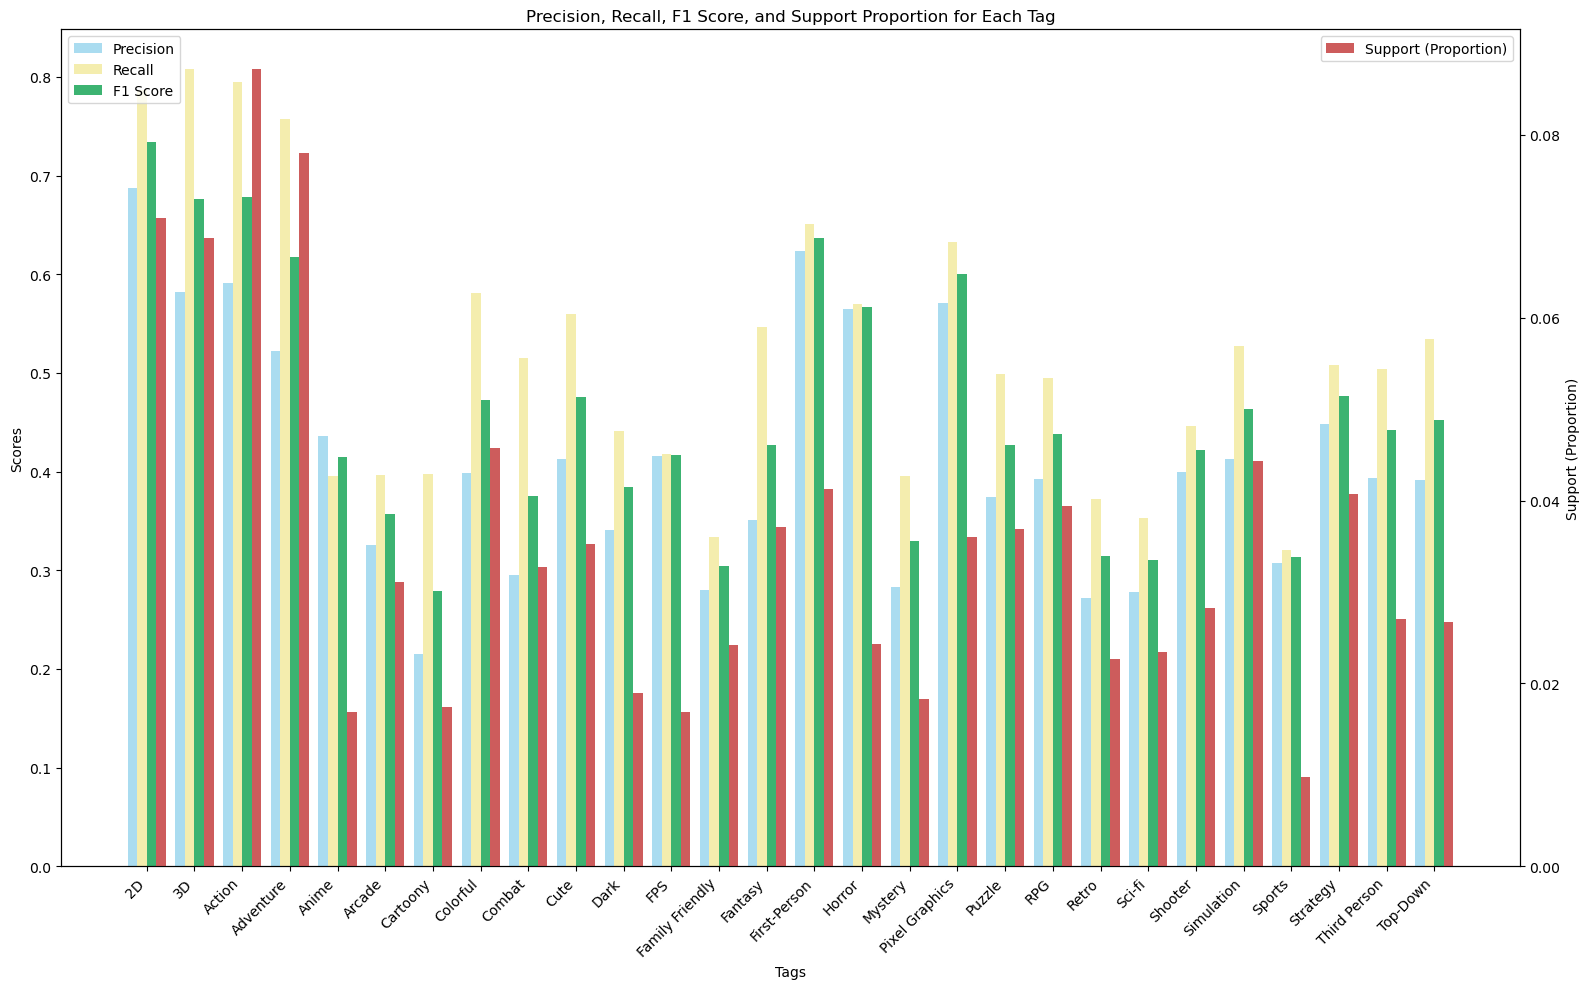

In [67]:
##PLOTTING THE RESULTS FOR EACH TAG

# Generate the classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=tags_to_use, output_dict=True)

# Extract metrics
labels = []
precisions = []
recalls = []
f1_scores = []
supports = []

for tag in tags_to_use:
    labels.append(tag)
    precisions.append(report_dict[tag]['precision'])
    recalls.append(report_dict[tag]['recall'])
    f1_scores.append(report_dict[tag]['f1-score'])
    supports.append(report_dict[tag]['support'])

# Convert supports to proportions
total_support = sum(supports)
support_proportions = [s / total_support for s in supports]

# Plot the metrics
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax1 = plt.subplots(figsize=(16, 10))

# Use a new color scheme
colors = ['#2F4F4F', '#228B22', '#8B4513', '#CD853F']
colors = ['#483D8B', '#008080', '#9370DB', '#20B2AA']
colors = ['#87CEEB', '#F0E68C', '#3CB371', '#CD5C5C']


# Plot precision, recall, F1 score
rects1 = ax1.bar(x - 1.5 * width, precisions, width, label='Precision', color=colors[0], alpha = .7)
rects2 = ax1.bar(x - 0.5 * width, recalls, width, label='Recall', color=colors[1], alpha = .7)
rects3 = ax1.bar(x + 0.5 * width, f1_scores, width, label='F1 Score', color=colors[2])

# Create a secondary y-axis for support proportions
ax2 = ax1.twinx()
rects4 = ax2.bar(x + 1.5 * width, support_proportions, width, label='Support (Proportion)', color=colors[3], alpha=1)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel('Tags')
ax1.set_ylabel('Scores')
ax2.set_ylabel('Support (Proportion)')
ax1.set_title('Precision, Recall, F1 Score, and Support Proportion for Each Tag')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')  # Rotate labels to prevent clashing
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')



fig.tight_layout()

plt.show()

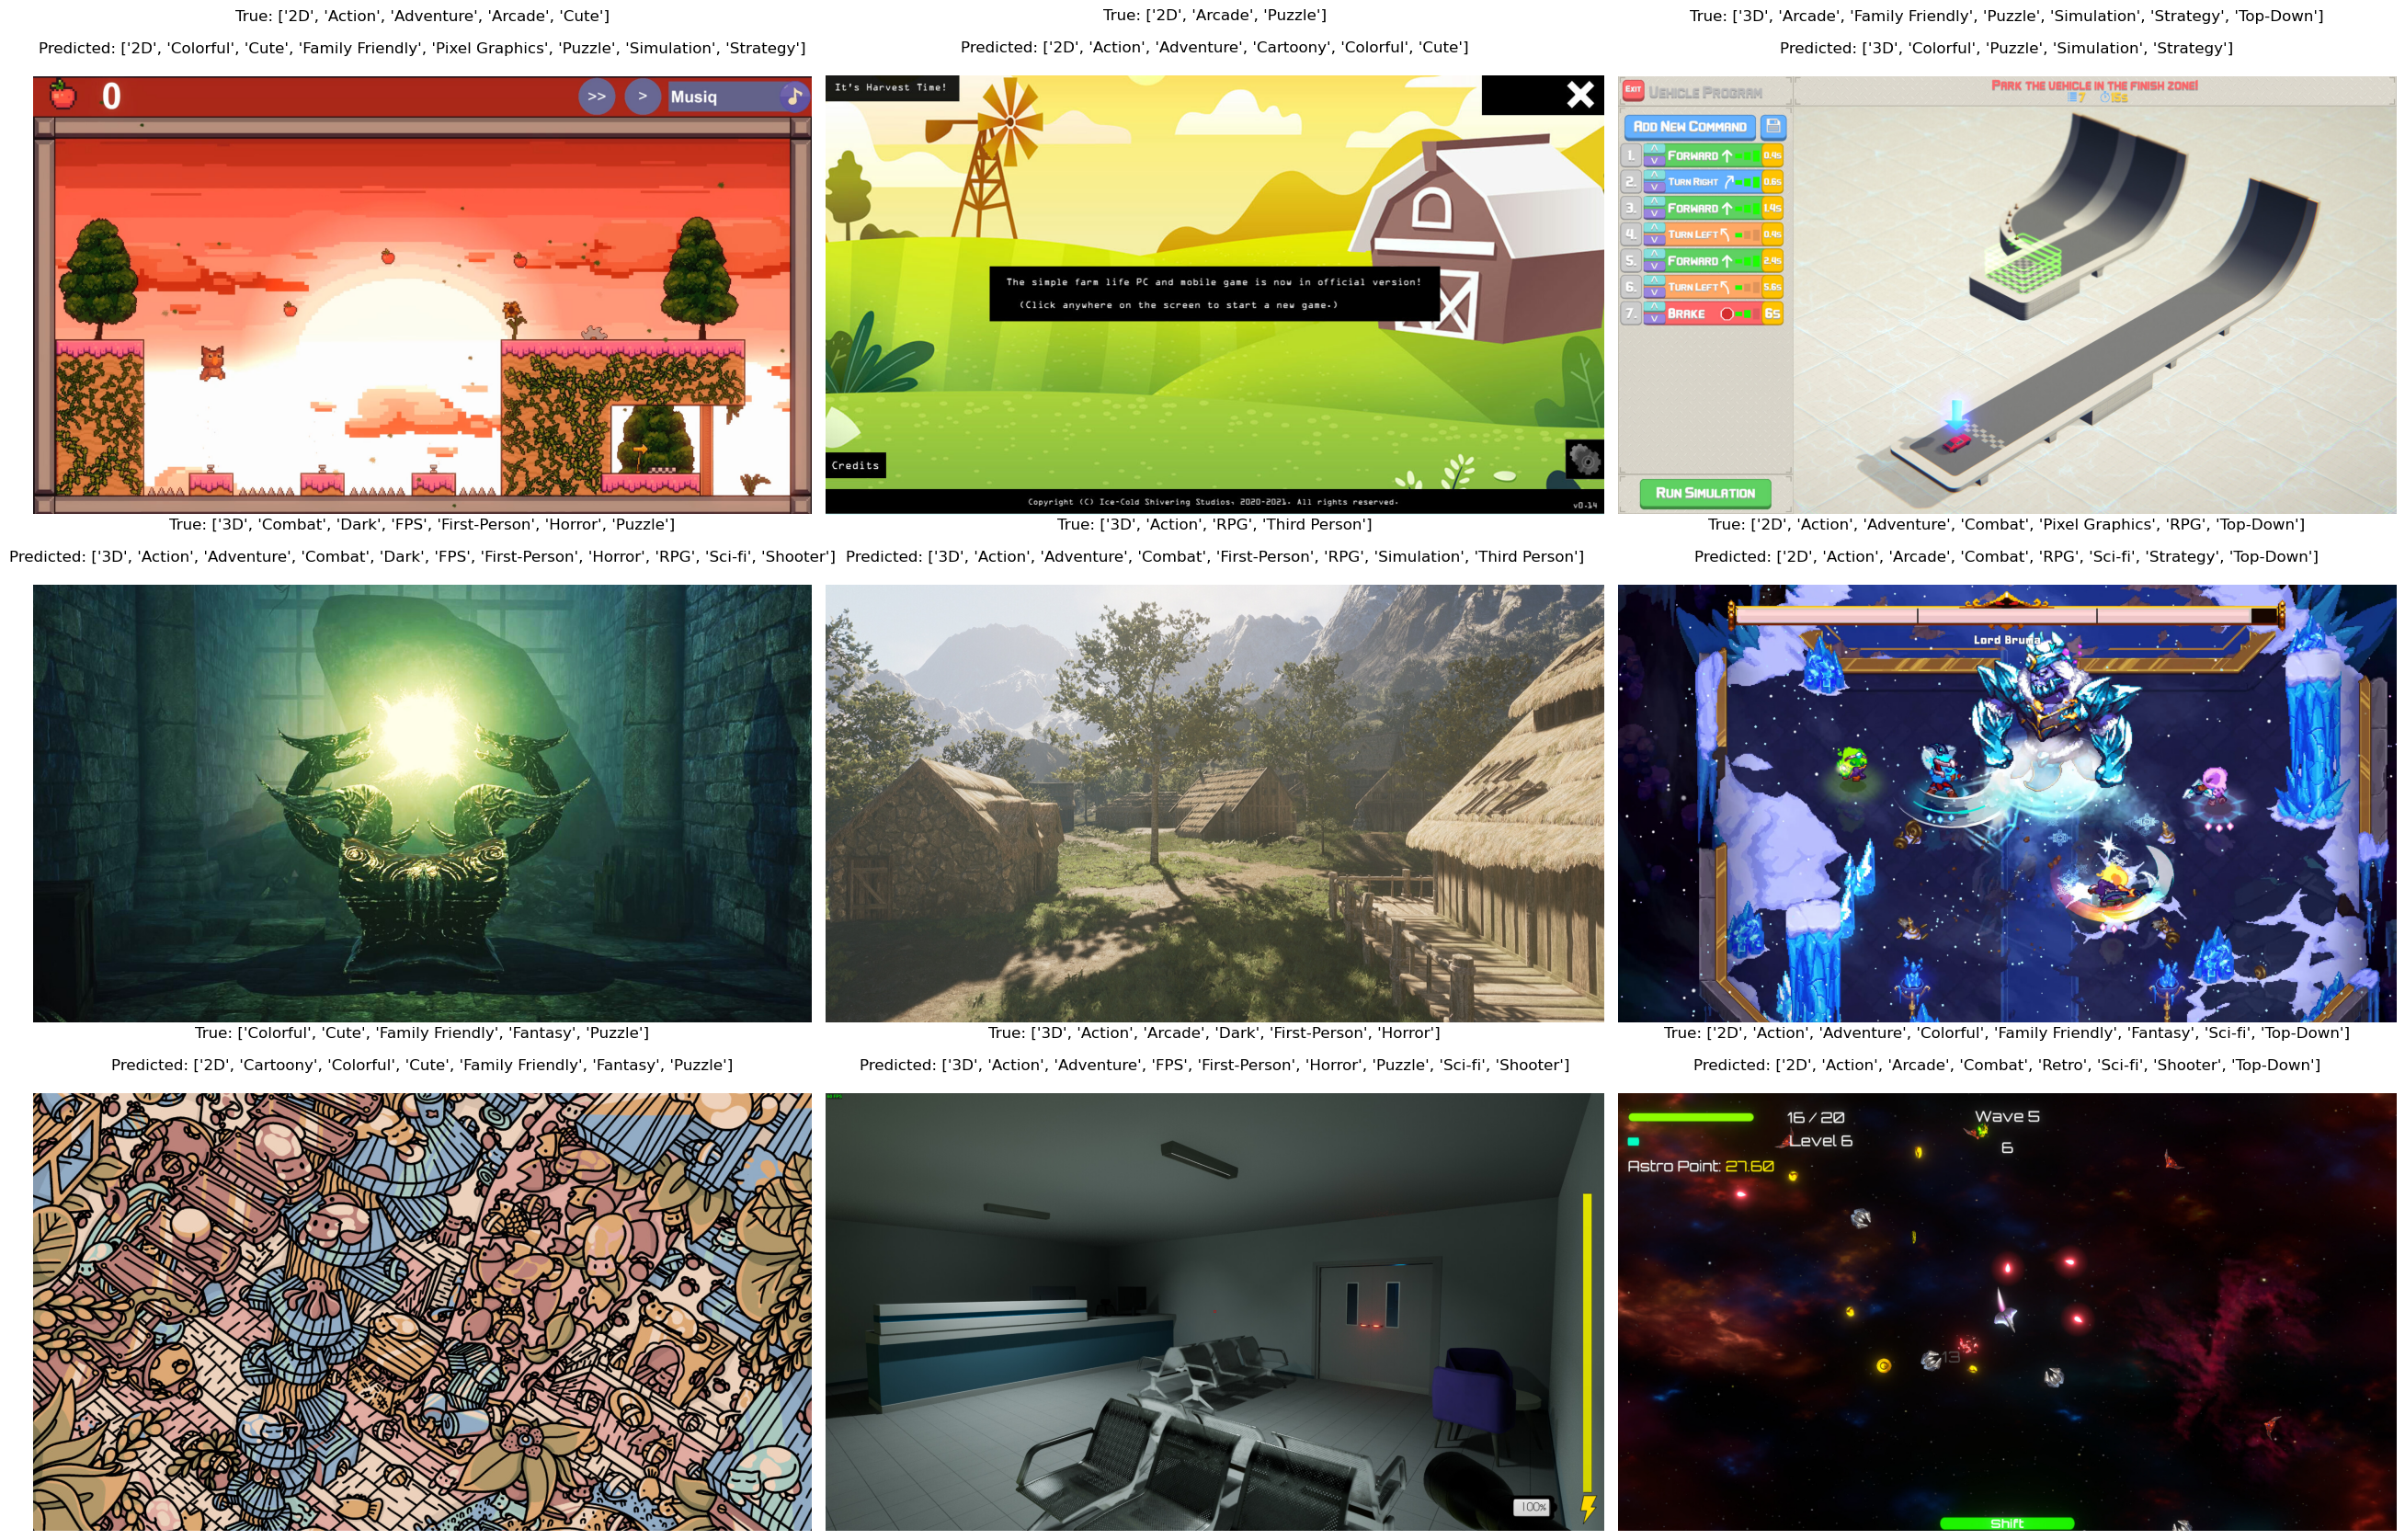

In [121]:
##GENERATING A RANDOM SAMPLE OF SCREENSHOTS FROM THE TEST SET

screenshot_paths = test_generator.filepaths
screenshot_paths = [path.replace("resized_images", "images") for path in screenshot_paths]

# Combine y_true, y_pred, and screenshot paths into a list of tuples
data = list(zip(y_true, y_pred, screenshot_paths))


# Sample 20 random instances
random.seed(4)  # Set random seed for reproducibility
random_instances = random.sample(data, 9)

# Get the tags for y_true and y_pred
tags_true = [[tags_to_use[i] for i, value in enumerate(instance[0]) if value == 1] for instance in random_instances]
tags_pred = [[tags_to_use[i] for i, value in enumerate(instance[1]) if value >= 0.5] for instance in random_instances]

screenshot_paths_sampled = [instance[2] for instance in random_instances]

# Plot the screenshots along with their true and predicted labels
plt.figure(figsize=(26, 17))
for i, (true_tags, pred_tags, screenshot_path) in enumerate(zip(tags_true, tags_pred, screenshot_paths_sampled), 1):
    plt.subplot(3, 3, i)
    plt.imshow(plt.imread(screenshot_path))
    plt.title(f'True: {true_tags}\n\nPredicted: {pred_tags}\n')
    plt.axis('off')

plt.tight_layout()
plt.show()